
# DETECTING HUMOUR IN TEXT
<img src="https://knowledgeone.ca/wp-content/uploads/2020/01/laughing1.jpg" style="width:100%;margin:auto;">

## Import necessary Libraries

In [69]:
# General libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")
from tensorflow.keras.models import load_model
import joblib

# preprocessing libraries
import calendar
import re
import string
from tqdm import tqdm
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer, PorterStemmer
nltk.download('vader_lexicon')
from sklearn import preprocessing
from imblearn.over_sampling import RandomOverSampler 
from sklearn.model_selection import train_test_split
from wordcloud import WordCloud,STOPWORDS
from textblob import TextBlob
import unidecode

# Evaluation metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier
from tensorflow.keras import layers

#Naive Bayes classifier process
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB

#Deep learning 
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense,Embedding, Dropout,Activation,LSTM
from keras import regularizers
from keras import initializers

#transformers
from transformers import BertTokenizer
from transformers import AutoTokenizer,BertTokenizer
from transformers import TFBertModel,BertModel
from transformers import RobertaTokenizer
from transformers import TFRobertaModel
from transformers import DistilBertTokenizerFast
from transformers import TFDistilBertModel
from transformers import TFAutoModel

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\718449\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\718449\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\718449\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\718449\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\718449\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
# read the data using pandas dataframe 
Humour_texts=pd.read_csv('Humour_dataset.csv')
Humour_texts.shape

(200000, 2)

In [3]:
Humour_texts.head(5)

,text,humor
0,"Joe biden rules out 2020 bid: 'guys, i'm not r...",False
1,Watch: darvish gave hitter whiplash with slow ...,False
2,What do you call a turtle without its shell? d...,True
3,5 reasons the 2016 election feels so personal,False
4,"Pasco police shot mexican migrant from behind,...",False


In [4]:
Humour_texts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    200000 non-null  object
 1   humor   200000 non-null  bool  
dtypes: bool(1), object(1)
memory usage: 1.7+ MB


In [5]:
# remame feature and replace boolean(True & False) labels to string(Humourous & Non-humourous) labels
Humour_texts.rename(columns={'humor': 'Humour'}, inplace=True)
Humour_texts['Humour'] = Humour_texts['Humour'].astype(str).str.replace('False', 'Non-humourous')
Humour_texts['Humour'] = Humour_texts['Humour'].astype(str).str.replace('True', 'Humourous')
Humour_texts.head()

,text,Humour
0,"Joe biden rules out 2020 bid: 'guys, i'm not r...",Non-humourous
1,Watch: darvish gave hitter whiplash with slow ...,Non-humourous
2,What do you call a turtle without its shell? d...,Humourous
3,5 reasons the 2016 election feels so personal,Non-humourous
4,"Pasco police shot mexican migrant from behind,...",Non-humourous


## Text Preprocessing

In [6]:
# covert to lower cases
def case_convert():
    Humour_texts.text = [i.lower() for i in Humour_texts.text.values]

# remove special characters
def remove_specials():
    Humour_texts.text =  [re.sub(r"[^a-zA-Z]"," ",text) for text in Humour_texts.text.values]
    
# remove shorthands or contractions
def remove_shorthands():
    CONTRACTION_MAP = {
    "ain't": "is not",
    "aren't": "are not",
    "can't": "cannot",
    "can't've": "cannot have",
    "'cause": "because",
    "could've": "could have",
    "couldn't": "could not",
    "couldn't've": "could not have",
    "didn't": "did not",
    "doesn't": "does not",
    "don't": "do not",
    "hadn't": "had not",
    "hadn't've": "had not have",
    "hasn't": "has not",
    "haven't": "have not",
    "he'd": "he would",                        #contraction map written out words was gotten from kaggle:
    "he'd've": "he would have",                #https://www.kaggle.com/code/vishnu0399/humour-detection-using-nlp
    "he'll": "he will",
    "he'll've": "he he will have",
    "he's": "he is",
    "how'd": "how did",
    "how'd'y": "how do you",
    "how'll": "how will",
    "how's": "how is",
    "i'd": "i would",
    "i'd've": "i would have",
    "i'll": "i will",
    "i'll've": "i will have",
    "i'm": "i am",
    "i've": "i have",
    "isn't": "is not",
    "it'd": "it would",
    "it'd've": "it would have",
    "it'll": "it will",
    "it'll've": "it will have",
    "it's": "it is",
    "let's": "let us",
    "ma'am": "madam",
    "mayn't": "may not",
    "might've": "might have",
    "mightn't": "might not",
    "mightn't've": "might not have",
    "must've": "must have",
    "mustn't": "must not",
    "mustn't've": "must not have",
    "needn't": "need not",
    "needn't've": "need not have",
    "o'clock": "of the clock",
    "oughtn't": "ought not",
    "oughtn't've": "ought not have",
    "shan't": "shall not",
    "sha'n't": "shall not",
    "shan't've": "shall not have",
    "she'd": "she would",
    "she'd've": "she would have",
    "she'll": "she will",
    "she'll've": "she will have",
    "she's": "she is",
    "should've": "should have",
    "shouldn't": "should not",
    "shouldn't've": "should not have",
    "so've": "so have",
    "so's": "so as",
    "that'd": "that would",
    "that'd've": "that would have",
    "that's": "that is",
    "there'd": "there would",
    "there'd've": "there would have",
    "there's": "there is",
    "they'd": "they would",
    "they'd've": "they would have",
    "they'll": "they will",
    "they'll've": "they will have",
    "they're": "they are",
    "they've": "they have",
    "to've": "to have",
    "wasn't": "was not",
    "we'd": "we would",
    "we'd've": "we would have",
    "we'll": "we will",
    "we'll've": "we will have",
    "we're": "we are",
    "we've": "we have",
    "weren't": "were not",
    "what'll": "what will",
    "what'll've": "what will have",
    "what're": "what are",
    "what's": "what is",
    "what've": "what have",
    "when's": "when is",
    "when've": "when have",
    "where'd": "where did",
    "where's": "where is",
    "where've": "where have",
    "who'll": "who will",
    "who'll've": "who will have",
    "who's": "who is",
    "who've": "who have",
    "why's": "why is",
    "why've": "why have",
    "will've": "will have",
    "won't": "will not",
    "won't've": "will not have",
    "would've": "would have",
    "wouldn't": "would not",
    "wouldn't've": "would not have",
    "y'all": "you all",
    "y'all'd": "you all would",
    "y'all'd've": "you all would have",
    "y'all're": "you all are",
    "y'all've": "you all have",
    "you'd": "you would",
    "you'd've": "you would have",
    "you'll": "you will",
    "you'll've": "you will have",
    "you're": "you are",
    "you've": "you have"
    }
    texts = []
    for text in Humour_texts.text.values:
        string = ""
        for word in text.split(" "):
            if word.strip() in list(CONTRACTION_MAP.keys()):
                string = string + " " + CONTRACTION_MAP[word]
            else:
                string = string + " " + word
        texts.append(string.strip())
    Humour_texts.text = texts

# convert accented characters like "á", "é", "ï", "ö", etc., into their non-accented versions like "a", "e", "i", "o", etc.
def remove_accents():
    Humour_texts.text = [unidecode.unidecode(text) for text in Humour_texts.text.values]

# normalize spacing of characters
def normalize_spaces():
    Humour_texts.text = [re.sub(r"\s+"," ",text) for text in Humour_texts.text.values]

# removing links
def remove_links():
    texts = []
    for text in Humour_texts.text.values:
        remove_https = re.sub(r'http\S+', '', text)
        remove_com = re.sub(r"\ [A-Za-z]*\.com", " ", remove_https)
        texts.append(remove_com)
    Humour_texts.text = texts

case_convert()
remove_links()
remove_shorthands()
remove_accents()
remove_specials()
normalize_spaces()

# defining another function to remove emojis and numbers, tokenize and stem words.
def preprocess_text(text):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               "]+", flags=re.UNICODE)
#      Replace emojis with empty string
    text=emoji_pattern.sub(r'', text)
    
    # Remove numbers
    text = re.sub(r'\d+', '', text)
    
    # Tokenize words
    words = word_tokenize(text)
    
    #stem words
    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in words]
    
    
    # Join the words back into a string
    text = ' '.join(words)
    
    return text
Humour_texts['text']=Humour_texts['text'].apply(preprocess_text) #apply functio to text data
Humour_texts.head()

,text,Humour
0,joe biden rule out bid guy i am not run,Non-humourous
1,watch darvish gave hitter whiplash with slow p...,Non-humourous
2,what do you call a turtl without it shell dead,Humourous
3,reason the elect feel so person,Non-humourous
4,pasco polic shot mexican migrant from behind n...,Non-humourous


In [7]:
# Define function to get value counts
def get_value_counts(col_name): 
    count = pd.DataFrame(Humour_texts[col_name].value_counts())
    percentage = pd.DataFrame(Humour_texts[col_name].value_counts(normalize=True).mul(100))
    value_counts_df = pd.concat([count, percentage], axis = 1)
    value_counts_df = value_counts_df.reset_index()
    value_counts_df.columns = ['humour', 'counts', 'percentage']
    value_counts_df.sort_values('humour', inplace = True)
    value_counts_df['percentage'] = value_counts_df['percentage'].apply(lambda x: round(x,2))
    value_counts_df = value_counts_df.reset_index(drop = True)
   
    return value_counts_df

df = get_value_counts('Humour')
df

,humour,counts,percentage
0,Humourous,100000,50.0
1,Non-humourous,100000,50.0


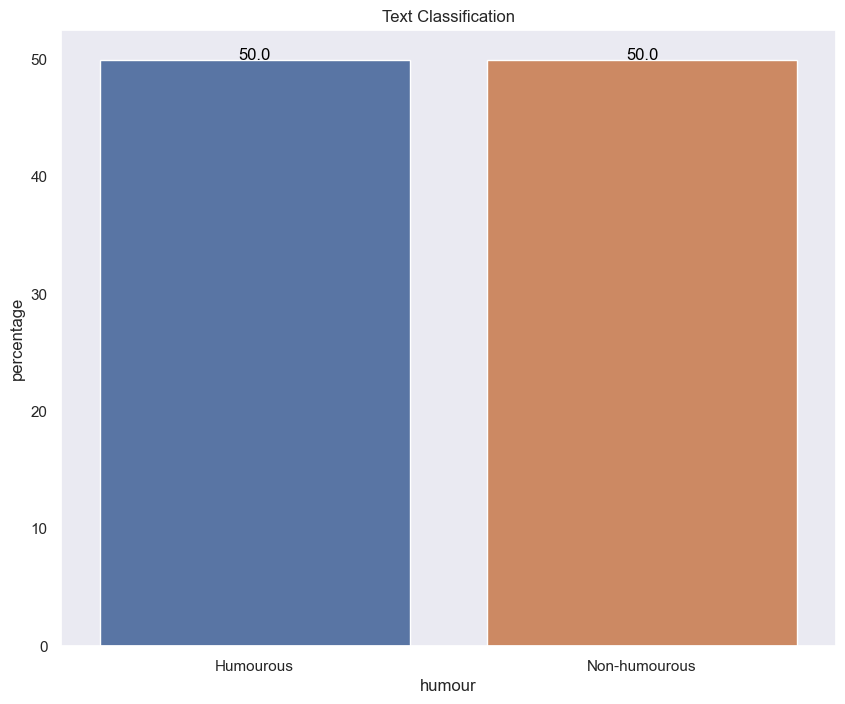

In [8]:
# plot a chart to see the distrubution of the humourous and non-humorous classes
sns.set_theme(style="dark")
plt.figure(figsize=(10, 8))
ax = sns.barplot(x="humour", y="percentage", data=df)
ax.set_title('Text Classification')

for index, row in df.iterrows():
    ax.text(row.name,row.percentage, round(row.percentage,1), color='black', ha="center")

## Wordcloud representation of words

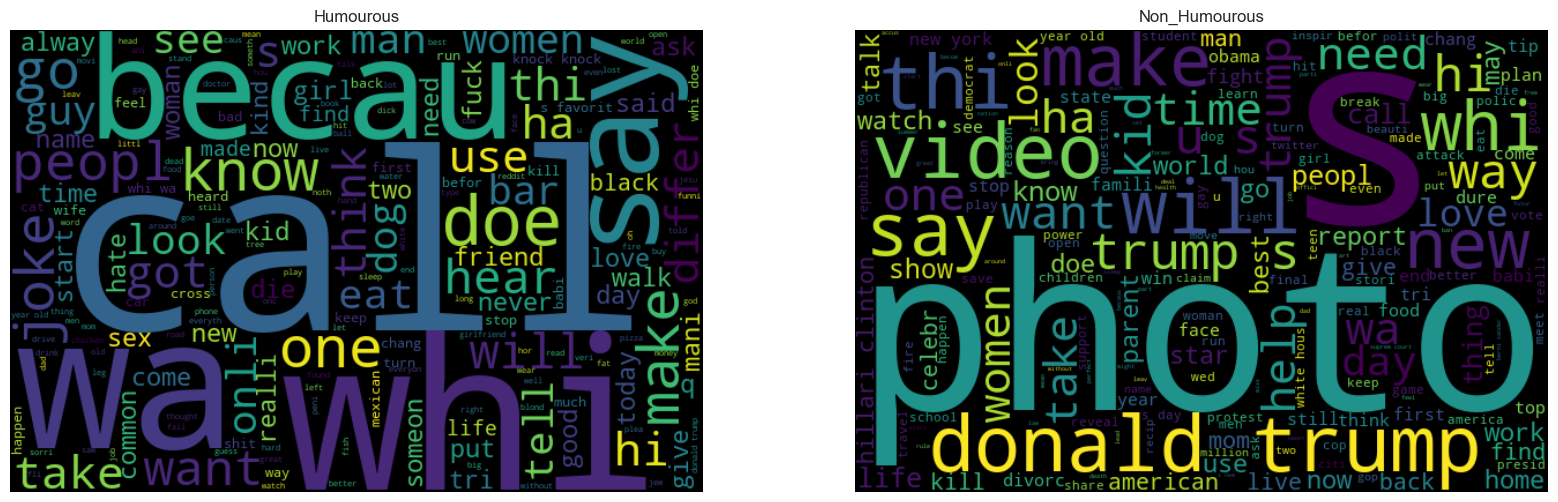

In [9]:
stopwords = set(STOPWORDS)
stopwords.update(['amp', 'https', 'co', 'rt'])

# Define the humourous and non-humourous
Humourous_text = Humour_texts[Humour_texts['Humour'] == 'Humourous']['text'].tolist()
Non_humourous_text = Humour_texts[Humour_texts['Humour'] == 'Non-humourous']['text'].tolist()

# Generate the word clouds for each sentiment
wc_Humourous = WordCloud(background_color='black', stopwords=stopwords, width=600, height=400).generate(' '.join(Humourous_text))
wc_Non_humourous = WordCloud(background_color='black', stopwords=stopwords, width=600, height=400).generate(' '.join(Non_humourous_text))



# Plot the word clouds

fig, axs = plt.subplots(1, 2, figsize=(20, 6))
axs[0].imshow(wc_Humourous, interpolation='bilinear')
axs[0].set_title('Humourous')
axs[0].axis('off')
axs[1].imshow(wc_Non_humourous, interpolation='bilinear')
axs[1].set_title('Non_Humourous')
axs[1].axis('off')
plt.show()

## Splitting Data into train,val and test and encoding y-variable

In [10]:
# assign txt and labels to x and y respectively 
X = Humour_texts['text'].values
y = Humour_texts['Humour'].values 

In [11]:
# splitting text into train,validation and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42) #split to train and test

X , y = X_train, y_train

 #split train further to val and train
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [12]:
# making a copy for machine learning classifier
y_train_le = y_train.copy()
y_valid_le = y_val.copy()
y_test_le = y_test.copy()

# label encode y as y should be a 1d array for naive bayes instead.
label_map = {'Non-humourous': 0, 'Humourous': 1}
y_train_le = np.array([label_map[label] for label in y_train_le])
y_valid_le = np.array([label_map[label] for label in y_valid_le])
y_test_le = np.array([label_map[label] for label in y_test_le])


In [13]:
# using one-hot encoding fo y in deep learning classifiers
ohe = preprocessing.OneHotEncoder()
y_train = ohe.fit_transform(np.array(y_train).reshape(-1, 1)).toarray()
y_valid = ohe.fit_transform(np.array(y_val).reshape(-1, 1)).toarray()
y_test = ohe.fit_transform(np.array(y_test).reshape(-1, 1)).toarray()

In [14]:
# checking how the data was split
print(f"TRAINING DATA: {X_train.shape[0]}\nVALIDATION DATA: {X_val.shape[0]}\nTESTING DATA: {X_test.shape[0]}" )

TRAINING DATA: 128000
VALIDATION DATA: 32000
TESTING DATA: 40000


## LSTM-RNN CLASSIFIER

In [15]:
# Define some hyperparameters
max_words = 10000 # Maximum number of words to include in the tokenizer
max_len = 200 # Maximum length of each input sequence
num_classes = 2 # Number of output classes


# Preprocess the text data
tokenizer = Tokenizer(num_words=max_words)

tokenizer.fit_on_texts(X_train)
train_sequences = tokenizer.texts_to_sequences(X_train) #converts text to integers
word_index = tokenizer.word_index
train_data = pad_sequences(train_sequences, maxlen=max_len)

val_sequences = tokenizer.texts_to_sequences(X_val)
val_data = pad_sequences(val_sequences, maxlen=max_len)  #pad sequences to max len

test_sequences = tokenizer.texts_to_sequences(X_test)
test_data = pad_sequences(test_sequences, maxlen=max_len)



print('Shape of data tensor:',train_data.shape)
print('Shape of data tensor:',val_data.shape)
print('Shape of data tensor:',test_data.shape)

Shape of data tensor: (128000, 200)
Shape of data tensor: (32000, 200)
Shape of data tensor: (40000, 200)


## Pretrained FastText + LSTM

In [70]:
embeddings_index = {}  #extract embeddibgs from GloVe and save in dictionary
fasttext_dir = "D:/wiki-news-300d-1M.vec/wiki-news-300d-1M.vec"
with open(fasttext_dir, encoding='utf8') as f:
    for line in f:
        values = line.split()
        if len(values) < 2:
            continue
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
print('found %s word vectors' % len(embeddings_index))


#embedding matrix
embedding_dim = 300 # Dimensionality 
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    if i >= vocab_size:
        continue
    embedding_vector = embeddings_index.get(word)
    if (embedding_vector is not None) and len(embedding_vector) > 0:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector

found 999995 word vectors


In [71]:
#define model architecture
model1 = Sequential()

model1.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], trainable=False))

model1.add(LSTM(128, return_sequences=True, kernel_initializer=initializers.glorot_uniform()))

model1.add(Dropout(0.4))

model1.add(LSTM(64, kernel_initializer=initializers.glorot_uniform()))

model1.add(Dropout(0.4))

model1.add(Dense(2, activation='softmax', kernel_regularizer=regularizers.l2(0.01), kernel_initializer=initializers.glorot_uniform()))

model1.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model1.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, None, 300)         10388100  
                                                                 
 lstm_4 (LSTM)               (None, None, 128)         219648    
                                                                 
 dropout_81 (Dropout)        (None, None, 128)         0         
                                                                 
 lstm_5 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_82 (Dropout)        (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 2)                 130       
                                                                 
Total params: 10,657,286
Trainable params: 269,186
Non

In [72]:
#train model
RNN_model_fasttext=model1.fit(train_data, y_train, validation_data=(val_data, y_valid), epochs=10, batch_size=32)

Epoch 1/10
4000/4000 [==============================] - 65s 16ms/step - loss: 0.2246 - accuracy: 0.9148 - val_loss: 0.1888 - val_accuracy: 0.9298
Epoch 2/10
4000/4000 [==============================] - 63s 16ms/step - loss: 0.1726 - accuracy: 0.9350 - val_loss: 0.1639 - val_accuracy: 0.9366
Epoch 3/10
4000/4000 [==============================] - 63s 16ms/step - loss: 0.1512 - accuracy: 0.9431 - val_loss: 0.1528 - val_accuracy: 0.9439
Epoch 4/10
4000/4000 [==============================] - 63s 16ms/step - loss: 0.1375 - accuracy: 0.9492 - val_loss: 0.1523 - val_accuracy: 0.9442
Epoch 5/10
4000/4000 [==============================] - 63s 16ms/step - loss: 0.1192 - accuracy: 0.9561 - val_loss: 0.1491 - val_accuracy: 0.9470
Epoch 6/10
4000/4000 [==============================] - 63s 16ms/step - loss: 0.1079 - accuracy: 0.9605 - val_loss: 0.1493 - val_accuracy: 0.9460
Epoch 7/10
4000/4000 [==============================] - 63s 16ms/step - loss: 0.0946 - accuracy: 0.9658 - val_loss: 0.1589 -

In [73]:
result_RNN_model_fasttext =model1.predict(test_data) #predict test data

1250/1250 [==============================] - 8s 6ms/step


In [74]:
y_pred_fasttext=  np.zeros_like(result_RNN_model_fasttext)
y_pred_fasttext[np.arange(len(y_pred_fasttext)), result_RNN_model_fasttext.argmax(1)] = 1

In [75]:
print('\tClassification Report for RNN:\n\n',classification_report(y_test,y_pred_fasttext , target_names=['Humorous','Non-humourous']))

	Classification Report for RNN:

                precision    recall  f1-score   support

     Humorous       0.96      0.93      0.94     19999
Non-humourous       0.93      0.96      0.94     20001

    micro avg       0.94      0.94      0.94     40000
    macro avg       0.94      0.94      0.94     40000
 weighted avg       0.94      0.94      0.94     40000
  samples avg       0.94      0.94      0.94     40000



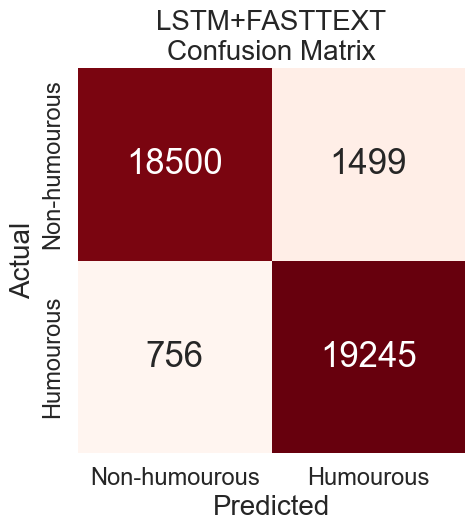

In [80]:
#define a function for confusion matrix which we will call for all the models
def conf_matrix(y, y_pred_fasttext, title):
    fig, ax =plt.subplots(figsize=(5,5))
    labels=['Non-humourous', 'Humourous']
    ax=sns.heatmap(confusion_matrix(y, y_pred_fasttext), annot=True, cmap="Reds", fmt='g', cbar=False, annot_kws={"size":25})
    plt.title(title, fontsize=20)
    ax.xaxis.set_ticklabels(labels, fontsize=17) 
    ax.yaxis.set_ticklabels(labels, fontsize=17)
    ax.set_ylabel('Actual', fontsize=20)
    ax.set_xlabel('Predicted', fontsize=20)
    plt.show()
    
    
    
#call confusion matrix    
conf_matrix(y_test.argmax(1), y_pred_fasttext.argmax(1),'LSTM+FASTTEXT\nConfusion Matrix')

In [77]:
df_FT = pd.DataFrame(RNN_model_fasttext.history)
df_FT["epoch"] = RNN_model_fasttext.epoch
df_FT

,loss,accuracy,val_loss,val_accuracy,epoch
0,0.224619,0.914820,0.188760,0.929750,0
1,0.172647,0.934961,0.163876,0.936625,1
2,0.151174,0.943148,0.152803,0.943937,2
3,0.137502,0.949188,0.152321,0.944188,3
4,0.119165,0.956125,0.149085,0.947000,4
5,0.107917,0.960477,0.149272,0.946000,5
6,0.094588,0.965828,0.158868,0.948219,6
7,0.083217,0.970383,0.169449,0.944031,7
8,0.071276,0.975195,0.185064,0.944687,8
9,0.061159,0.979336,0.177968,0.944687,9


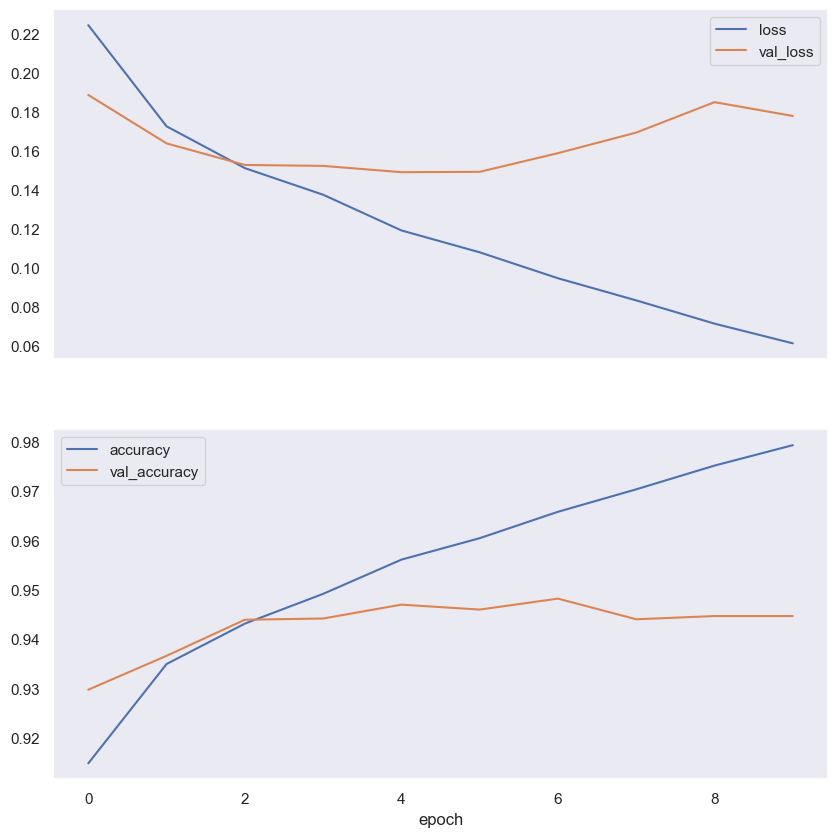

In [78]:
fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(10, 10))
df_FT.plot(x="epoch", y=["loss", "val_loss"], ax=ax0)
df_FT.plot(x="epoch", y=["accuracy", "val_accuracy"], ax=ax1);

In [81]:
model1.save('model_lstm+fasttext.h5')  #save model

## Pretrained Glove+ LSTM

In [26]:
#file path to embedding vectors size 300 dimensions
glove_dir = "D:/glove.42B.300d/glove.42B.300d.txt"
embeddings_index = {}   #extract embeddibgs from GloVe and save in dictionary
with open(glove_dir, encoding='utf8') as f:
    for line in f:
        values = line.split()
        if len(values) < 2:
            continue
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embeddings_index[word] = coefs
        
print('Found %s word vectors:'%len(embeddings_index))  

#create embedding matrix
embedding_dim = 300
vocab_size = len(word_index) + 1
embedding_matrix = np.zeros((vocab_size, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

Found 1917494 word vectors:


In [27]:
#define model architecture
model2 = Sequential()

model2.add(Embedding(vocab_size, embedding_dim, weights=[embedding_matrix], trainable=False))

model2.add(LSTM(128, return_sequences=True, kernel_initializer=initializers.glorot_uniform()))

model2.add(Dropout(0.4))

model2.add(LSTM(64, kernel_initializer=initializers.glorot_uniform()))

model2.add(Dropout(0.4))

model2.add(Dense(2, activation='softmax', kernel_regularizer=regularizers.l2(0.01), kernel_initializer=initializers.glorot_uniform()))

model2.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

model2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 300)         10388100  
                                                                 
 lstm_2 (LSTM)               (None, None, 128)         219648    
                                                                 
 dropout_2 (Dropout)         (None, None, 128)         0         
                                                                 
 lstm_3 (LSTM)               (None, 64)                49408     
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 2)                 130       
                                                                 
Total params: 10,657,286
Trainable params: 269,186
Non

In [28]:
#train model
RNN_model_GloVe=model2.fit(train_data, y_train, validation_data=(val_data, y_valid), epochs=10, batch_size=32)

Epoch 1/10
4000/4000 [==============================] - 65s 16ms/step - loss: 0.2068 - accuracy: 0.9230 - val_loss: 0.1607 - val_accuracy: 0.9395
Epoch 2/10
4000/4000 [==============================] - 63s 16ms/step - loss: 0.1505 - accuracy: 0.9451 - val_loss: 0.1532 - val_accuracy: 0.9449
Epoch 3/10
4000/4000 [==============================] - 63s 16ms/step - loss: 0.1197 - accuracy: 0.9559 - val_loss: 0.1395 - val_accuracy: 0.9485
Epoch 4/10
4000/4000 [==============================] - 64s 16ms/step - loss: 0.1137 - accuracy: 0.9585 - val_loss: 0.1481 - val_accuracy: 0.9475
Epoch 5/10
4000/4000 [==============================] - 64s 16ms/step - loss: 0.0836 - accuracy: 0.9701 - val_loss: 0.1509 - val_accuracy: 0.9505
Epoch 6/10
4000/4000 [==============================] - 64s 16ms/step - loss: 0.0673 - accuracy: 0.9768 - val_loss: 0.1617 - val_accuracy: 0.9479
Epoch 7/10
4000/4000 [==============================] - 64s 16ms/step - loss: 0.0544 - accuracy: 0.9820 - val_loss: 0.1609 -

In [29]:
result_RNN_model_GloVe =model2.predict(test_data) #predict test

1250/1250 [==============================] - 8s 6ms/step


In [30]:
test_loss, test_accuracy = model2.evaluate(test_data,y_test)
print('Test Accuracy:', test_accuracy)
print('Test Loss:', test_loss)

1250/1250 [==============================] - 9s 7ms/step - loss: 0.2077 - accuracy: 0.9504
Test Accuracy: 0.9504250288009644
Test Loss: 0.2076883763074875


In [31]:
y_pred_glove=  np.zeros_like(result_RNN_model_GloVe)
y_pred_glove[np.arange(len(y_pred_glove)), result_RNN_model_GloVe.argmax(1)] = 1

In [32]:
print('\tClassification Report for RNN:\n\n',classification_report(y_test,y_pred_glove , target_names=['Humorous','Non-humourous']))

	Classification Report for RNN:

                precision    recall  f1-score   support

     Humorous       0.95      0.95      0.95     19999
Non-humourous       0.95      0.95      0.95     20001

    micro avg       0.95      0.95      0.95     40000
    macro avg       0.95      0.95      0.95     40000
 weighted avg       0.95      0.95      0.95     40000
  samples avg       0.95      0.95      0.95     40000



In [33]:
# RNN_model_GloVe.epoch

In [34]:
# RNN_model_GloVe.history

In [35]:
df = pd.DataFrame(RNN_model_GloVe.history)
df["epoch"] = RNN_model_GloVe.epoch
df

,loss,accuracy,val_loss,val_accuracy,epoch
0,0.206825,0.922992,0.160729,0.939469,0
1,0.150492,0.945063,0.153212,0.944938,1
2,0.119739,0.955922,0.139478,0.948531,2
3,0.113711,0.958516,0.148121,0.947469,3
4,0.083599,0.970148,0.150906,0.950500,4
5,0.067308,0.976758,0.161683,0.947906,5
6,0.054357,0.982016,0.160930,0.950312,6
7,0.045157,0.985836,0.182784,0.948000,7
8,0.040542,0.987391,0.202487,0.948187,8
9,0.034164,0.989664,0.216502,0.948469,9


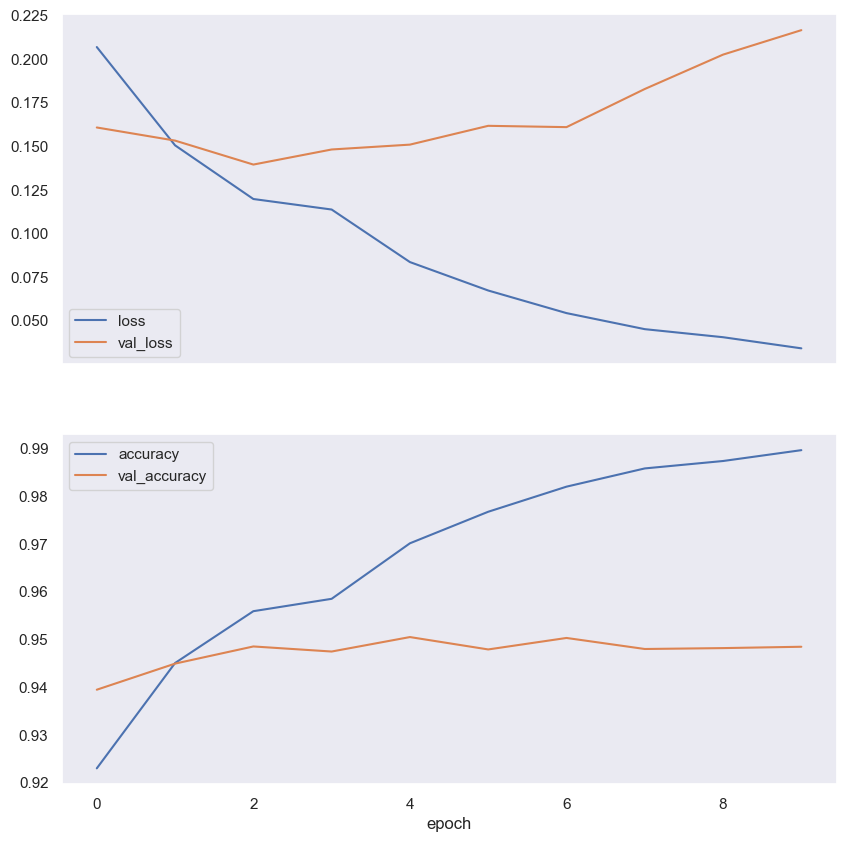

In [36]:
fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(10, 10))
df.plot(x="epoch", y=["loss", "val_loss"], ax=ax0)
df.plot(x="epoch", y=["accuracy", "val_accuracy"], ax=ax1);

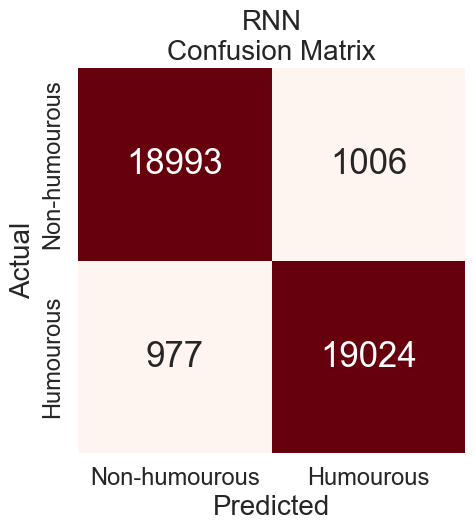

In [37]:
conf_matrix(y_test.argmax(1), y_pred_glove.argmax(1),'RNN\nConfusion Matrix')

In [38]:
model2.save('model_lstm+glove.h5')


The LSTM models both performed well. However LSTM combined with GloVe performed better than LSTM combined with FastText with a 1% difference.

## DISTILBERT

In [39]:
# Instantiate DistilBERT tokenizer...we use the Fast version to optimize runtime
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

In [40]:
# Define the maximum number of words to tokenize (DistilBERT can tokenize up to 512)
MAX_LEN = 128


# Define function to encode text data in batches
def tokenize(texts,max_len=MAX_LEN): 
    input_ids = []
    attention_masks = []
    
    for i in range(len(texts)):
        
        encoded = tokenizer.encode_plus(texts[i],
                                        add_special_tokens=True,
                                        
                                        max_length=MAX_LEN,
                                        
                                        truncation=True,
                                        
                                        padding='max_length',
                                        
                                        return_attention_mask=True)
                                                                 
            
        input_ids.append(encoded['input_ids'])
        attention_masks.append(encoded['attention_mask'])
        
    return np.array(input_ids),np.array(attention_masks)
    
#apply the tokenizer function to the train, validation and test sets
train_input_ids, train_attention_masks = tokenize(X_train, MAX_LEN)

val_input_ids, val_attention_masks = tokenize(X_val, MAX_LEN)

test_input_ids, test_attention_masks = tokenize(X_test, MAX_LEN)

In [41]:
distilBERT = TFDistilBertModel.from_pretrained('distilbert-base-uncased')

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


In [42]:
num_classes=2
def build_model(distilBERT, max_len, num_classes):
    input_ids = tf.keras.Input(shape=(max_len,), dtype='int32')
    attention_masks = tf.keras.Input(shape=(max_len,), dtype='int32')

    # Use the DistilBERT model as the base
    distilbert_model = distilBERT.from_pretrained('distilbert-base-uncased')
    sequence_output = distilbert_model([input_ids, attention_masks])[0]

    # Apply GRU layer with return sequences to capture sequential information
    gru_output = tf.keras.layers.GRU(128, return_sequences=True)(sequence_output)

    # Apply attention mechanism to focus on important features
    attention = tf.keras.layers.Attention()([gru_output, gru_output])

    # Apply global average pooling and global max pooling
    avg_pooling = tf.keras.layers.GlobalAveragePooling1D()(attention)
    max_pooling = tf.keras.layers.GlobalMaxPooling1D()(attention)

    # Concatenate the average pooling and max pooling representations
    concat = tf.keras.layers.Concatenate()([avg_pooling, max_pooling])

    # Add a dense layer with dropout for classification
    x = tf.keras.layers.Dense(256, activation='relu')(concat)
    x = tf.keras.layers.Dropout(0.5)(x)

    # Output layer with softmax activation for classification
    output = tf.keras.layers.Dense(2, activation='softmax')(x)

    # Create the model
    model = tf.keras.models.Model(inputs=[input_ids, attention_masks], outputs=output)

    # Compile the model with appropriate optimizer and loss function
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [43]:
model3 = build_model(distilBERT, MAX_LEN,num_classes)
model3.summary()

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertModel: ['vocab_transform.bias', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_projector.bias']
- This IS expected if you are initializing TFDistilBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFDistilBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFDistilBertModel for predictions without further training.


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 tf_distil_bert_model_1 (TFDist  TFBaseModelOutput(l  66362880   ['input_1[0][0]',                
 ilBertModel)                   ast_hidden_state=(N               'input_2[0][0]']                
                                one, 128, 768),                                                   
                                 hidden_states=None                                           

In [44]:
#train model
history_distilbert = model3.fit([train_input_ids, train_attention_masks],y_train,validation_data=([val_input_ids, val_attention_masks], y_valid),
epochs=5,batch_size=32 )

Epoch 1/5
4000/4000 [==============================] - 474s 118ms/step - loss: 0.1552 - accuracy: 0.9400 - val_loss: 0.1127 - val_accuracy: 0.9568
Epoch 2/5
4000/4000 [==============================] - 471s 118ms/step - loss: 0.0872 - accuracy: 0.9677 - val_loss: 0.1011 - val_accuracy: 0.9630
Epoch 3/5
4000/4000 [==============================] - 470s 118ms/step - loss: 0.0522 - accuracy: 0.9812 - val_loss: 0.1094 - val_accuracy: 0.9637
Epoch 4/5
4000/4000 [==============================] - 471s 118ms/step - loss: 0.0285 - accuracy: 0.9902 - val_loss: 0.1441 - val_accuracy: 0.9602
Epoch 5/5
4000/4000 [==============================] - 471s 118ms/step - loss: 0.0176 - accuracy: 0.9937 - val_loss: 0.1451 - val_accuracy: 0.9641


In [45]:
result_distil_bert = model3.predict([test_input_ids,test_attention_masks])

1250/1250 [==============================] - 42s 33ms/step


In [46]:
y_pred_distilbert =  np.zeros_like(result_distil_bert)
y_pred_distilbert[np.arange(len(y_pred_distilbert)), result_distil_bert.argmax(1)] = 1
print('\tClassification Report for DISTILBERT:\n\n',classification_report(y_test,y_pred_distilbert, target_names=['Humourous', 'Non-humourous']))

	Classification Report for DISTILBERT:

                precision    recall  f1-score   support

    Humourous       0.97      0.96      0.96     19999
Non-humourous       0.96      0.97      0.96     20001

    micro avg       0.96      0.96      0.96     40000
    macro avg       0.96      0.96      0.96     40000
 weighted avg       0.96      0.96      0.96     40000
  samples avg       0.96      0.96      0.96     40000



In [47]:
df_distilbert = pd.DataFrame(history_distilbert.history)
df_distilbert["epoch"] = history_distilbert.epoch
df_distilbert

,loss,accuracy,val_loss,val_accuracy,epoch
0,0.155183,0.940039,0.112669,0.956781,0
1,0.087243,0.967672,0.101135,0.962969,1
2,0.052171,0.981180,0.109424,0.963656,2
3,0.028464,0.990211,0.144057,0.960187,3
4,0.017553,0.993750,0.145146,0.964094,4


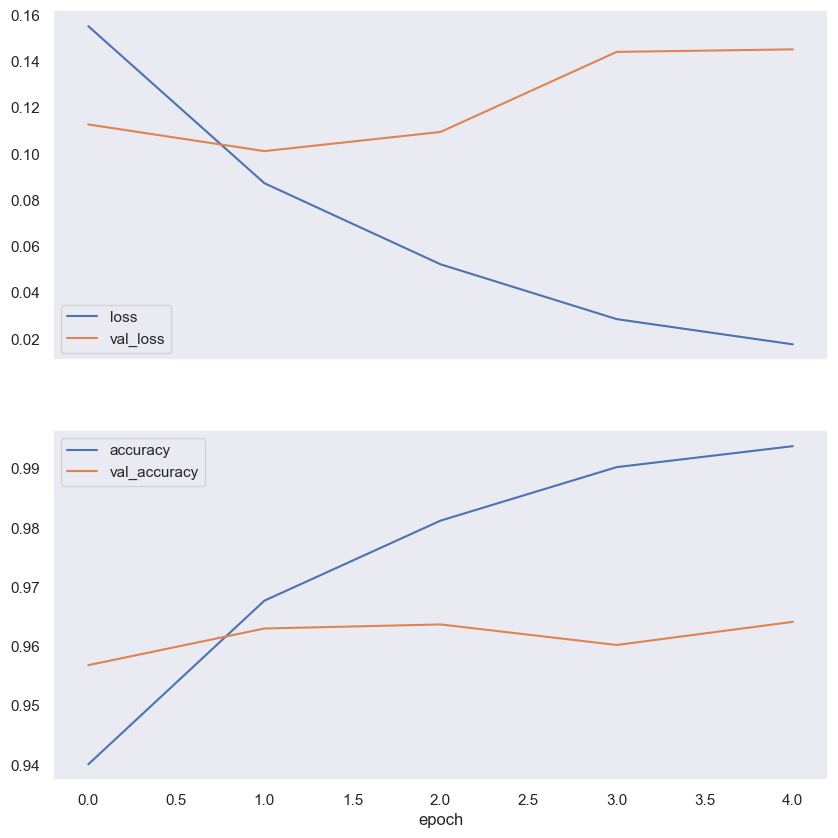

In [48]:
fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(10, 10))
df_distilbert.plot(x="epoch", y=["loss", "val_loss"], ax=ax0)
df_distilbert.plot(x="epoch", y=["accuracy", "val_accuracy"], ax=ax1);

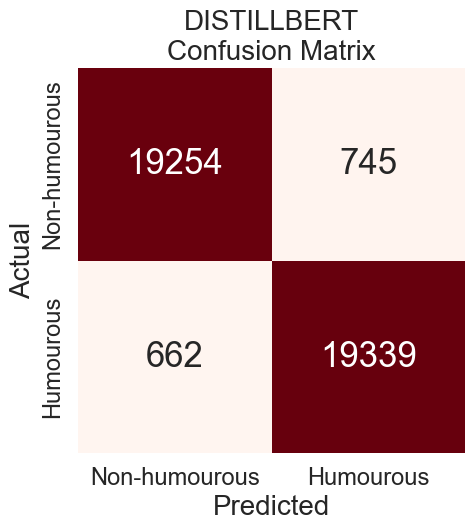

In [49]:
conf_matrix(y_test.argmax(1), y_pred_distilbert.argmax(1),'DISTILLBERT\nConfusion Matrix') #generate confusion matrix

In [50]:
model3.save('model_distilbert.h5') #save model

## BERT

In [51]:
#custom tokenizer function and call the encode_plus method of the BERT tokenizer.

MAX_LEN=128

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

def tokenize(data,max_len=MAX_LEN) :
    
    input_ids = []
    attention_masks = []
    
    for i in range(len(data)):
        encoded = tokenizer.encode_plus(data[i],
                                        add_special_tokens=True,
                                        max_length=MAX_LEN,
                                        truncation=True,
                                        padding='max_length',
                                        return_attention_mask=True)
        
        input_ids.append(encoded['input_ids'])
        
        attention_masks.append(encoded['attention_mask'])
        
    return np.array(input_ids),np.array(attention_masks)


#apply the tokenizer function to the train, validation and test sets
train_input_ids, train_attention_masks = tokenize(X_train, MAX_LEN)

val_input_ids, val_attention_masks = tokenize(X_val, MAX_LEN)

test_input_ids, test_attention_masks = tokenize(X_test, MAX_LEN)

In [52]:
bert_model = TFBertModel.from_pretrained('bert-base-uncased')  #import the BERT model from the pretrained library

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFBertModel: ['cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing TFBertModel from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
All the weights of TFBertModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions w

In [53]:
num_classes=2
def create_model(bert_model, max_len, num_classes):
    input_ids = tf.keras.Input(shape=(max_len,), dtype='int32')
    attention_masks = tf.keras.Input(shape=(max_len,), dtype='int32')

   
    sequence_output = bert_model([input_ids, attention_masks])[0]

    # Apply GRU layer with return sequences to capture sequential information
    gru_output = tf.keras.layers.GRU(128, return_sequences=True)(sequence_output)

    # Apply attention mechanism to focus on important features
    attention = tf.keras.layers.Attention()([gru_output, gru_output])

    # Apply global average pooling and global max pooling
    avg_pooling = tf.keras.layers.GlobalAveragePooling1D()(attention)
    max_pooling = tf.keras.layers.GlobalMaxPooling1D()(attention)

    # Concatenate the average pooling and max pooling representations
    concat = tf.keras.layers.Concatenate()([avg_pooling, max_pooling])

    # Add a dense layer with dropout for classification
    x = tf.keras.layers.Dense(256, activation='relu')(concat)
    x = tf.keras.layers.Dropout(0.5)(x)

    # Output layer with softmax activation for classification
    output = tf.keras.layers.Dense(2, activation='softmax')(x)

    # Create the model
    model = tf.keras.models.Model(inputs=[input_ids, attention_masks], outputs=output)

    # Compile the model with appropriate optimizer and loss function
    optimizer = tf.keras.optimizers.Adam(learning_rate=1e-5)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    return model

In [54]:
model4 = create_model(bert_model,MAX_LEN,num_classes)
model4.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 tf_bert_model (TFBertModel)    TFBaseModelOutputWi  109482240   ['input_3[0][0]',                
                                thPoolingAndCrossAt               'input_4[0][0]']                
                                tentions(last_hidde                                               
                                n_state=(None, 128,                                         

In [55]:
history_bert = model4.fit([train_input_ids, train_attention_masks],y_train,validation_data=([val_input_ids, val_attention_masks],y_valid),
epochs=5, batch_size=32)

Epoch 1/5
4000/4000 [==============================] - 903s 225ms/step - loss: 0.1452 - accuracy: 0.9445 - val_loss: 0.1131 - val_accuracy: 0.9578
Epoch 2/5
4000/4000 [==============================] - 893s 223ms/step - loss: 0.0744 - accuracy: 0.9729 - val_loss: 0.0947 - val_accuracy: 0.9670
Epoch 3/5
4000/4000 [==============================] - 895s 224ms/step - loss: 0.0374 - accuracy: 0.9869 - val_loss: 0.1150 - val_accuracy: 0.9673
Epoch 4/5
4000/4000 [==============================] - 893s 223ms/step - loss: 0.0202 - accuracy: 0.9932 - val_loss: 0.1362 - val_accuracy: 0.9685
Epoch 5/5
4000/4000 [==============================] - 892s 223ms/step - loss: 0.0136 - accuracy: 0.9955 - val_loss: 0.1288 - val_accuracy: 0.9691


In [56]:
result_bert = model4.predict([test_input_ids,test_attention_masks])

1250/1250 [==============================] - 81s 64ms/step


In [57]:
y_pred_bert =  np.zeros_like(result_bert)
y_pred_bert[np.arange(len(y_pred_bert)), result_bert.argmax(1)] = 1
print('\tClassification Report for DISTILBERT:\n\n',classification_report(y_test,y_pred_bert, target_names=['Humourous', 'Non-humourous']))

	Classification Report for DISTILBERT:

                precision    recall  f1-score   support

    Humourous       0.97      0.96      0.97     19999
Non-humourous       0.96      0.97      0.97     20001

    micro avg       0.97      0.97      0.97     40000
    macro avg       0.97      0.97      0.97     40000
 weighted avg       0.97      0.97      0.97     40000
  samples avg       0.97      0.97      0.97     40000



In [58]:
df_bert = pd.DataFrame(history_bert.history)
df_bert["epoch"] = history_bert.epoch
df_bert

,loss,accuracy,val_loss,val_accuracy,epoch
0,0.145213,0.944539,0.113111,0.957812,0
1,0.074439,0.972906,0.094698,0.967031,1
2,0.037446,0.986859,0.115038,0.967281,2
3,0.020241,0.993172,0.136167,0.968469,3
4,0.013630,0.995500,0.128752,0.969125,4


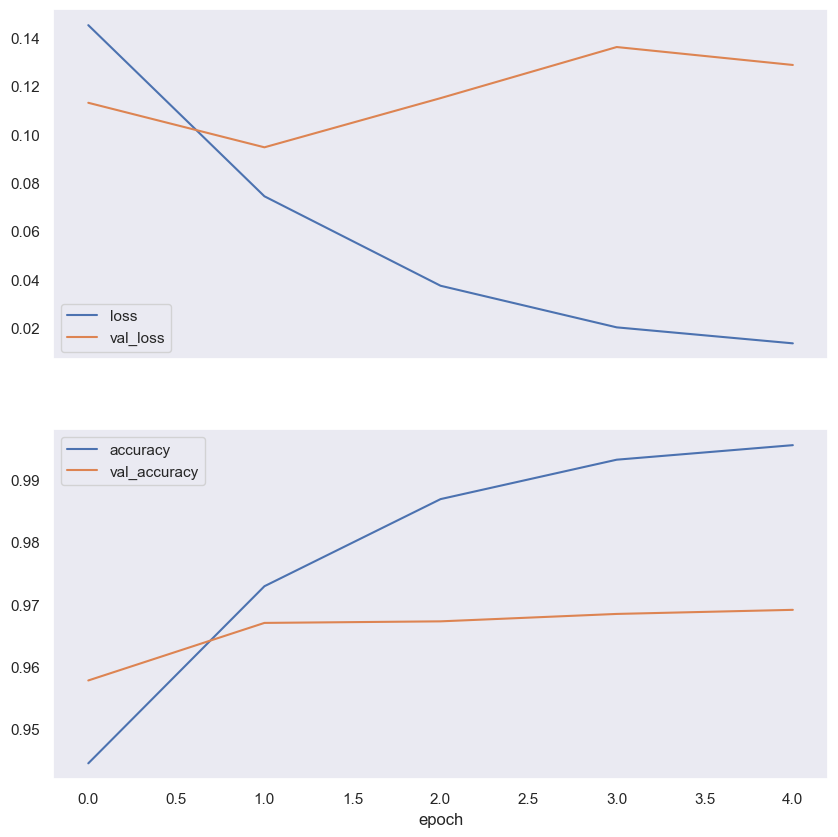

In [59]:
fig, (ax0, ax1) = plt.subplots(nrows=2, sharex=True, figsize=(10, 10))
df_bert.plot(x="epoch", y=["loss", "val_loss"], ax=ax0)
df_bert.plot(x="epoch", y=["accuracy", "val_accuracy"], ax=ax1);

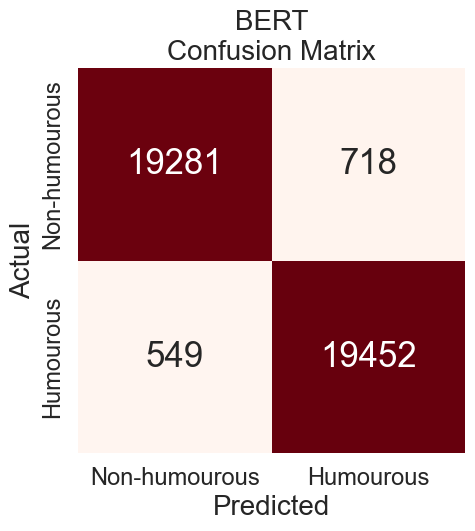

In [60]:
conf_matrix(y_test.argmax(1), y_pred_bert.argmax(1),'BERT\nConfusion Matrix')

The BERT model performed better tan the Distilbert model with 1% difference, however bert took a longer time to train because of its comptational load.

## NAIVE BAYES CLASSIFIER

In [61]:
#we will use countvectorizer to convert text to matrix
clf = CountVectorizer()  
X_train_cv =  clf.fit_transform(X_train)
X_val_cv =clf.transform(X_val)
X_test_cv = clf.transform(X_test)

#to give a more informative(importance) representation text
tf_transformer = TfidfTransformer(use_idf=True).fit(X_train_cv) 
X_train_tf = tf_transformer.transform(X_train_cv)
X_val_tf =tf_transformer.transform(X_val_cv)
X_test_tf = tf_transformer.transform(X_test_cv)

#naives bayes classifier for text
model5 = MultinomialNB()  
model5.fit(X_train_tf, y_train_le)
val_pred = model5.predict(X_val_tf)
nb_pred = model5.predict(X_test_tf)
y_train_pred = model5.predict(X_train_tf)



#getting validation accuracy
val_acc = accuracy_score(y_valid_le, val_pred)
training_accuracy = accuracy_score(y_train_le, y_train_pred)
print('Validation accuracy:', val_acc)
print('Training accuracy:', training_accuracy)

Validation accuracy: 0.9066875
Training accuracy: 0.9206015625


In [62]:
print('\tClassification Report for Naive Bayes:\n\n',classification_report(y_test_le,nb_pred, target_names=['Humourous', 'Non-humourous']))

	Classification Report for Naive Bayes:

                precision    recall  f1-score   support

    Humourous       0.93      0.89      0.91     20001
Non-humourous       0.89      0.93      0.91     19999

     accuracy                           0.91     40000
    macro avg       0.91      0.91      0.91     40000
 weighted avg       0.91      0.91      0.91     40000



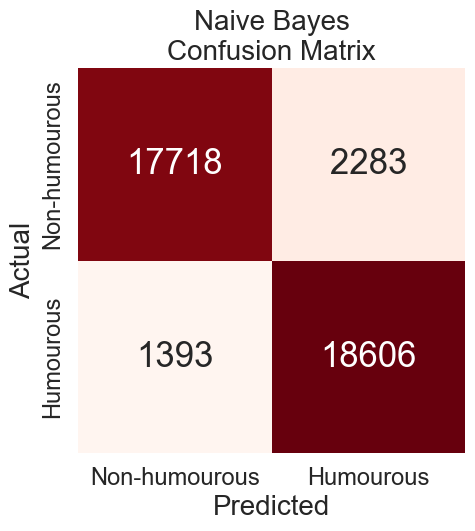

In [63]:
conf_matrix(y_test_le, nb_pred,'Naive Bayes\nConfusion Matrix')

In [64]:
joblib.dump(model5, 'model5.pkl')

['model5.pkl']

## HYPERPARAMETER TUNNING FOR NAIVE BAYES

In [65]:
param_grid = {
    'alpha': [0.1, 0.5, 1.0, 1.5, 2.0],
    'fit_prior': [True, False],  # Whether to learn class prior probabilities or not
}

# Perform Grid Search with Cross-Validation
nb_classifier = MultinomialNB()
grid_search = GridSearchCV(nb_classifier, param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_tf, y_train_le)

# Step 6: Evaluate Results
best_params = grid_search.best_params_
best_accuracy = grid_search.best_score_

print("Best Parameters:", best_params)
print("Best Accuracy:", best_accuracy)

# Step 7: Evaluate the best model on the validation set
best_nb_classifier = MultinomialNB(alpha=best_params['alpha'], fit_prior=best_params['fit_prior'])
best_nb_classifier.fit(X_train_tf, y_train_le)
y_pred = best_nb_classifier.predict(X_val_tf)
accuracy_on_val_set = accuracy_score(y_valid_le, y_pred)
print("Accuracy on Validation Set:", accuracy_on_val_set)

Best Parameters: {'alpha': 1.0, 'fit_prior': True}
Best Accuracy: 0.907140625
Accuracy on Validation Set: 0.9066875


In [66]:
joblib.dump(best_nb_classifier, 'naive_bayes_model.pkl')

['naive_bayes_model.pkl']

The Naive Bayes performed slightly better without the hyperparemeter tunning with 1% difference

## SENTIMENT ANALYSIS  (After thought)

Sentiment analysis of humour requires models to grasp the contextual nuances, potential multiple meanings, and emotions associated with humour which is essential as humour is subjective and some may consider it offensive. This aspect of research is important as it helps machines better understand humour and the sentiments that may be attached.

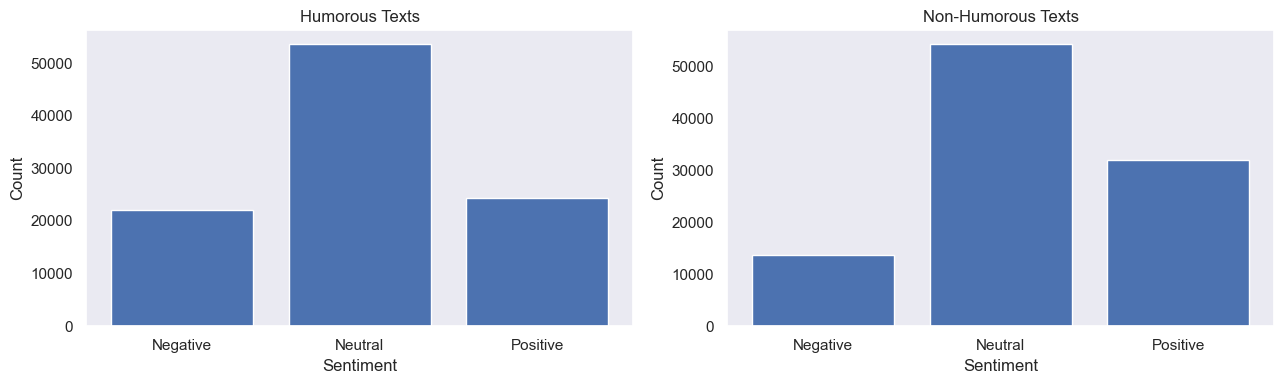

In [67]:
Humour_texts['Humour'] = Humour_texts['Humour'].map({'Non_humorous':0,'Humourous':1})


sentiment_humorous = []
sentiment_non_humorous = []

for text, humour_label in zip(Humour_texts.text.values, Humour_texts.Humour.values):
    polarity = TextBlob(text).sentiment.polarity
    if polarity < 0:
        sentiment_label = "Negative"
    elif polarity == 0:
        sentiment_label = "Neutral"
    else:
        sentiment_label = "Positive"
    
    if humour_label == 1:
        sentiment_humorous.append(sentiment_label)
    else:
        sentiment_non_humorous.append(sentiment_label)

plt.figure(figsize=(13, 4))
plt.subplot(1, 2, 1)
un_humorous, count_humorous = np.unique(sentiment_humorous, return_counts=True)
plt.bar(un_humorous, count_humorous)
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.title("Humorous Texts")

plt.subplot(1, 2, 2)
un_non_humorous, count_non_humorous = np.unique(sentiment_non_humorous, return_counts=True)
plt.bar(un_non_humorous, count_non_humorous)
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.title("Non-Humorous Texts")

plt.tight_layout()
plt.show()

## INFERENCE (Testing the LSTM models on sentenses found on kaggle dataset)

In [108]:
maxlen = 128
tokenizer = Tokenizer(maxlen)
def predict(joke):
    joke = tokenizer.texts_to_sequences([joke])
    if len(joke)>maxlen:
        joke=joke[:maxlen]
    joke = pad_sequences(joke, maxlen=maxlen, dtype='float', padding='post', value=0.0)
    joke = np.array(joke)
    pred = model1.predict(joke)
    pred = np.argmax(pred, axis=-1)
    decode_label = {0:'Non-humourous', 1:'Humourous'}
    pred = decode_label[pred[0]]
    return pred

# Load Model 1
model1 = load_model("model_lstm+fasttext.h5")

In [109]:
joke = "people say time is precious but they waste it right after they say it themselves"
pred = predict(joke)
print("Joke:",joke)
print('Humour detected: ',pred)

1/1 [==============================] - 1s 686ms/step
Joke: people say time is precious but they waste it right after they say it themselves
Humour detected:  Humourous


In [110]:
maxlen = 128
tokenizer = Tokenizer(maxlen)
def predict(joke):
    joke = tokenizer.texts_to_sequences([joke])
    if len(joke)>maxlen:
        joke=joke[:maxlen]
    joke = pad_sequences(joke, maxlen=maxlen, dtype='float', padding='post', value=0.0)
    joke = np.array(joke)
    pred = model2.predict(joke)
    pred = np.argmax(pred, axis=-1)
    decode_label = {0:'Non-humourous', 1:'Humourous'}
    pred = decode_label[pred[0]]
    return pred

# Load Model 2
model2 = load_model("model_lstm+glove.h5")

In [111]:
joke = "the dead girl was only five years old"
pred = predict(joke)
print("Joke:",joke)
print('Humour detected: ',pred)

1/1 [==============================] - 0s 329ms/step
Joke: the dead girl was only five years old
Humour detected:  Non-humourous
